In [ ]:
!git clone https://@github.com/sinhajiya/Face_Recognition_from_Features_using_Yale_Face_Database.git


fatal: destination path 'Face_Recognition_from_Features_using_Yale_Face_Database' already exists and is not an empty directory.


In [ ]:
!git config --global user.email "@gmail.com"
!git config --global user.name ""

In [ ]:
%cd Face_Recognition_from_Features_using_Yale_Face_Database

[Errno 2] No such file or directory: 'Face_Recognition_from_Features_using_Yale_Face_Database'
/content/Face_Recognition_from_Features_using_Yale_Face_Database


In [ ]:
%ls

 codes/                        glcm_features/   lbp_full_features/   processed_data/
 data/                         image.png        LoG_transformed/     README.md
'DSP_Project_LoG&GLCM.ipynb'   label/           main.ipynb
 gabor_features/               lbp_features/    normalized_data/


## Load the data directly from github repo using Github API

In [ ]:
import os
import requests

# GitHub API URL for the processed_data folder
api_url = "https://api.github.com/repos/sinhajiya/Face_Recognition_from_Features_using_Yale_Face_Database/contents/processed_data"

# Headers to increase request limit (optional)
headers = {
    "Accept": "application/vnd.github.v3+json"
}

# Directory to save files locally
save_dir = "processed_data"
os.makedirs(save_dir, exist_ok=True)

# Get the list of files from the API
response = requests.get(api_url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    files = response.json()

    # Loop over the files and download them
    for file in files:
        file_name = file['name']
        download_url = file['download_url']

        print(f"Downloading {file_name} ...")
        file_response = requests.get(download_url)

        if file_response.status_code == 200:
            # Save file locally
            with open(os.path.join(save_dir, file_name), "wb") as f:
                f.write(file_response.content)
            print(f"Successfully downloaded {file_name}")
        else:
            print(f"Failed to download {file_name}")
else:
    print(f"Failed to retrieve file list from GitHub API, status code: {response.status_code}")

## **Laplacian of Gaussian (LoG).**

---



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Directory where the original .npy files are stored
data_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/normalized_data"
# Directory to save the transformed .npy files
log_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed"
os.makedirs(log_dir, exist_ok=True)

# List all .npy files in the directory
npy_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]


# Function to apply Laplacian of Gaussian (LoG) transformation
def laplacian_of_gaussian(image, kernel_size=3):
    # Convert the image to CV_64F before applying GaussianBlur
    blurred_image = cv2.GaussianBlur(image.astype(np.float64), (kernel_size, kernel_size), 0)
    log_image = cv2.Laplacian(blurred_image, cv2.CV_64F)
    return log_image

# Process and save each image
for file_name in npy_files:
    # Load the .npy file
    image_path = os.path.join(data_dir, file_name)
    image = np.load(image_path)

    # apply LoG transformation
    log_image = laplacian_of_gaussian(image)

    # Save the transformed image as a new .npy file
    transformed_path = os.path.join(log_dir, file_name)
    np.save(transformed_path, log_image)
    print(f"Transformed and saved: {transformed_path}")

Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject04.noglasses.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject09.normal.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject12.leftlight.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject12.normal.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject01.wink.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject11.rightlight.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject13.sleepy.npy
Transformed and saved: /content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject06.sur

The code applies Laplacian of Gaussian(LoG), and then stores all the transformed images in the folder named as "LoG_transformed".

### **Some code to display the output, inshort display the "LoG_transformed" images**.

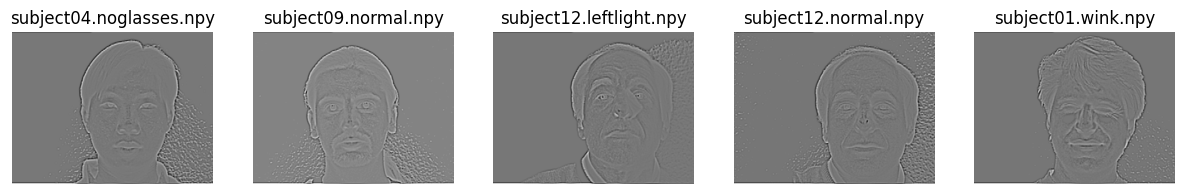

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory where the LoG transformed .npy files are saved
log_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed"

# List all .npy files in the LoG transformed directory
log_files = [f for f in os.listdir(log_dir) if f.endswith('.npy')]

# Number of images to display
num_images_to_display = 5

# Set up a horizontal subplot
plt.figure(figsize=(15, 5))  # Adjust width and height as needed

for i, file_name in enumerate(log_files[:num_images_to_display]):
    # Load the transformed .npy file
    log_image_path = os.path.join(log_dir, file_name)
    log_image = np.load(log_image_path)

    # Add subplot in a 1x5 grid (1 row, 5 columns)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(log_image, cmap='gray')
    plt.title(file_name)
    plt.axis('off')

plt.show()

## **Gray Level Co-occurence Matrix (GLCM)**

---

Since GLCM doesn’t directly produce a transformed image but rather a set of feature values, we’ll save these feature values as a numerical vector for each image.

Steps:
1. Load each `.npy` image file from the processed_data directory.
2. Compute the GLCM for each image using `skimage.feature.greycomatrix`.
3. Extract texture features from the GLCM, such as contrast, energy, homogeneity, and correlation.
4. Save these features in a new directory `(processed_data/glcm_features)` as .npy files.

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage import feature

# Define paths
data_folder = '/content/Face_Recognition_from_Features_using_Yale_Face_Database/normalized_data'
output_folder = '/content/Face_Recognition_from_Features_using_Yale_Face_Database/glcm_features'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to calculate GLCM features
def calculate_glcm_features(image):

    # Scale the image to the range [0, 255] for GLCM calculation
    gray_image_scaled = (image * 255).astype(np.uint8)

    # Calculate GLCM
    glcm = feature.graycomatrix(gray_image_scaled, [1], [0], symmetric=True, normed=True)

    # Extract features
    features = {
        'contrast': feature.graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': feature.graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': feature.graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': feature.graycoprops(glcm, 'energy')[0, 0],
        'correlation': feature.graycoprops(glcm, 'correlation')[0, 0],
        'entropy': -np.sum(glcm[0] * np.log2(glcm[0] + 1e-10))  # Adding small value to avoid log(0)
    }

    return features

# Iterate through images in the processed_data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.npy') and filename != 'LoG_transformed':
        image_path = os.path.join(data_folder, filename)
        image = np.load(image_path)

        # Calculate features
        features = calculate_glcm_features(image)

        # Save features to a CSV file
        feature_vector = pd.DataFrame(features, index=[0])
        feature_vector.to_csv(os.path.join(output_folder, f'{os.path.splitext(filename)[0]}_features.csv'), index=False)

print("Feature extraction completed and saved in", output_folder)

Feature extraction completed and saved in /content/Face_Recognition_from_Features_using_Yale_Face_Database/glcm_features


# Merging all the feature vectors.

In [ ]:
import numpy as np
import pandas as pd

# Load features
log_features = np.load('/content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed/subject01.centerlight.npy')
gabor_features = np.load('/content/Face_Recognition_from_Features_using_Yale_Face_Database/gabor_features/subject01.centerlight.npy_gabor.npy')
glcm_features = pd.read_csv('/content/Face_Recognition_from_Features_using_Yale_Face_Database/glcm_features/subject01.centerlight_features.csv').values
lbp_features = np.load('/content/Face_Recognition_from_Features_using_Yale_Face_Database/lbp_full_features/subject01.centerlight.npy_lbp.npy')

# Reshape gabor_features and glcm_features to have 2 dimensions
gabor_features = gabor_features.reshape(1, -1)  # Reshape to (1, number_of_gabor_features)
glcm_features = glcm_features.reshape(1, -1)  # Reshape to (1, number_of_glcm_features)


# Concatenate features along the second axis (feature axis)
# Since log_features and lbp_features have the same shape, concatenate them first
image_features = np.concatenate((log_features, lbp_features), axis=0) #This is done to merge log and lbp as they have compatible shapes

#Now, since these features are image level features (243,320) each, and gabor and glcm features are image-level features
#we need to perform flattening
flattened_image_features= image_features.flatten() #Reshape into (243*320,)
#Reshape gabor and glcm into 1D as well
flattened_gabor_features = gabor_features.flatten()
flattened_glcm_features = glcm_features.flatten()

# Change axis to 0 for concatenation of 1-D arrays
combined_features = np.concatenate((flattened_image_features, flattened_gabor_features, flattened_glcm_features), axis=None) #Concatenate all into 1D feature vector

In [ ]:
label = []
for filename in sorted(os.listdir("/content/Face_Recognition_from_Features_using_Yale_Face_Database/LoG_transformed")):
    if filename.endswith('.npy'):
        names = filename.split('.')
        l = names[0][7:]
        l = int(l)
        label.append(l)

In [ ]:
np.array(label)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [ ]:
# Define the path to save the label list
output_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/label"
os.makedirs(output_dir, exist_ok=True)
label_path = os.path.join(output_dir, "labels.npy")

# Save the list of labels as a NumPy array
np.save(label_path, np.array(label))

print(f"Saved all labels to {label_path}")

Saved all labels to /content/Face_Recognition_from_Features_using_Yale_Face_Database/label/labels.npy


In [ ]:
gabor_features = np.load('/content/Face_Recognition_from_Features_using_Yale_Face_Database/gabor_features/subject01.centerlight.npy_gabor.npy')
gabor_features

array([3.1325217e-02, 3.1561812e-04, 3.1591389e-02, 2.6013618e-04,
       3.1325221e-02, 3.4786970e-04, 3.2822824e-01, 2.0736063e-02,
       3.2954976e-01, 2.0349910e-02, 3.2822824e-01, 1.9811114e-02,
       5.0935930e-01, 4.8264757e-02, 5.0730753e-01, 4.7128875e-02,
       5.0935936e-01, 4.6605546e-02], dtype=float32)